In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# import pyro
# import pyro.distributions as dist
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# from pyro.nn import AutoRegressiveNN

sns.set_theme(font_scale=1.2, style="ticks")
import matplotlib

matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42
colors = sns.color_palette()

from src.train import estimate_mutual_information, train_estimator
from src.utils import mi_schedule

gaussian_dim = 20
data_params = {"dim": gaussian_dim, "batch_size": 128, "cubic": None}

critic_params = {
    "dim": gaussian_dim,
    "layers": 1,
    "embed_dim": 512,
    "hidden_dim": 512,
    "activation": "relu",
}

opt_params = {
    "iterations": 20000,
    "learning_rate": 1e-3,
}

# Baselines

In [ ]:
# baselines
estimator_lists = ["infonce", "nwj", "js", "dv", "smile"]
# estimator_lists = ["infonce"]

In [ ]:
for cubic in [None, True]:
    data_params["cubic"] = cubic
    for batch_size in [data_params["batch_size"]]:
        print("batch_size: ", batch_size)
        mi_numpys = dict()
        train_objs_numpys = dict()
        for critic_type in ["concat"]:
            mi_numpys[critic_type] = dict()
            train_objs_numpys[critic_type] = dict()
            for estimator in estimator_lists:
                baseline_string = "unnormalized" if estimator == "tuba" else "constant"
                mi_params = dict(estimator=estimator, critic=critic_type, baseline=baseline_string)
                # if False:
                #     mis, p_norm = train_estimator(critic_params, data_params, mi_params, opt_params)
                # else:
                mis, train_objs = train_estimator(critic_params, data_params, mi_params, opt_params)
                mi_numpys[critic_type][f"{estimator}"] = mis
                train_objs_numpys[critic_type][f"{estimator}"] = train_objs

                print("estimator", estimator)

        cubic_str = "" if cubic is None else "_cubic"
        np.savez(f"baselines_mi_values{cubic_str}_{str(batch_size)}.npz", **mi_numpys)
        np.savez(
            f"baselines_train_objs_values{cubic_str}_{str(batch_size)}.npz",
            **train_objs_numpys,
        )

In [ ]:
batch_size = data_params["batch_size"]
mi_numpys = np.load(f"baselines_mi_values_{str(batch_size)}.npz", allow_pickle=True)
mi_numpys_cubic = np.load(f"baselines_mi_values_cubic_{str(batch_size)}.npz", allow_pickle=True)


def find_name(name):
    if "dv_clip_" in name:
        clip = name.split("_")[-1]
        return f"dv_clip_ ($\\tau = {clip}$)"
    else:
        return {
            "infonce": "CPC",
            "js": "JS",
            "nwj": "NWJ",
            "dv": "DV (MINE)",
            "smile": "SMILE",
            "variational_f_js": "Variational MI Bounds",
            "probabilistic_classifier": "Probabilistic Classifier",
            "density_matching": "Density Matching II",
            "density_matching_lagrange": "Density Matching I",
            "density_ratio_fitting": "Density-Ratio Fitting",
            "squared_mutual_information": "SMI",
            "ncp": "NCP",
        }[name]


def find_legend(label):
    return {"concat": "Joint critic", "separable": "Separable critic"}[label]


ncols = len(estimator_lists)
nrows = 1
fig, axs = plt.subplots(nrows, ncols, figsize=(4 * ncols, 4 * nrows))
axs = np.ravel(axs)

mi_true = mi_schedule(opt_params["iterations"])

for i, estimator in enumerate(estimator_lists):
    key = f"{estimator}"
    plt.sca(axs[i])
    plt.title(find_name(key), fontsize=18)
    for net in ["concat"]:
        mis = mi_numpys[net].item()[key]
        mis_cubic = mi_numpys_cubic[net].item()[key]

        EMA_SPAN = 200
        p1 = plt.plot(mis, alpha=0.3)[0]
        mis_smooth = pd.Series(mis).ewm(span=EMA_SPAN).mean()
        plt.plot(mis_smooth, c=p1.get_color(), label="Gaussian")
        p2 = plt.plot(mis_cubic, alpha=0.3)[0]
        mis_smooth_cubic = pd.Series(mis_cubic).ewm(span=EMA_SPAN).mean()
        plt.plot(mis_smooth_cubic, c=p2.get_color(), label="Cubic")
    plt.ylim(0, 12)
    plt.xlim(0, 20000)
    plt.plot(mi_true, color="k", label="True MI")
    if estimator == "infonce":
        plt.ylabel("MI (nats)")
        plt.xlabel("Steps")
        plt.axhline(np.log(128), color="k", ls="--", label="log(bs)")
        plt.legend()

plt.gcf().tight_layout()
plt.savefig(f"baselines_mi_gauss_results_{str(batch_size)}.pdf", bbox_inches=None)

# Our Methods

In [ ]:
estimator_lists = [
    "ncp",
    "variational_f_js",
    "probabilistic_classifier",
    # "density_matching_lagrange",
    "density_matching",
    "density_ratio_fitting",
]  # , 'squared_mutual_information']

In [ ]:
for cubic in [None, True]:
    data_params["cubic"] = cubic
    for batch_size in [data_params["batch_size"]]:
        print("batch_size: ", batch_size)
        mi_numpys = dict()
        train_objs_numpys = dict()
        for critic_type in ["concat"]:
            mi_numpys[critic_type] = dict()
            train_objs_numpys[critic_type] = dict()
            for estimator in estimator_lists:
                baseline_string = "unnormalized" if estimator == "tuba" else "constant"
                mi_params = dict(estimator=estimator, critic=critic_type, baseline=baseline_string)
                if False:
                    mis, p_norm = train_estimator(critic_params, data_params, mi_params, opt_params)
                else:
                    mis, train_objs = train_estimator(critic_params, data_params, mi_params, opt_params)
                mi_numpys[critic_type][f"{estimator}"] = mis
                train_objs_numpys[critic_type][f"{estimator}"] = train_objs

                print("estimator", estimator)

        cubic_str = "" if cubic is None else "_cubic"
        np.savez(f"ours_mi_values{cubic_str}_{str(batch_size)}.npz", **mi_numpys)
        np.savez(
            f"ours_train_objs_values{cubic_str}_{str(batch_size)}.npz",
            **train_objs_numpys,
        )

# Just re-running NCP

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# import pyro
# import pyro.distributions as dist
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# from pyro.nn import AutoRegressiveNN

sns.set_theme(font_scale=1.2, style="ticks")
import matplotlib

matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42
colors = sns.color_palette()

from src.train import estimate_mutual_information, train_estimator
from src.utils import mi_schedule

gaussian_dim = 20
data_params = {"dim": gaussian_dim, "batch_size": 128, "cubic": None}

critic_params = {
    "dim": gaussian_dim,
    "layers": 1,
    "embed_dim": 512,
    "hidden_dim": 512,
    "activation": "relu",
}

ESTIMATORE = "ncp"
# mis_dict = dict()
# for cubic in [None, True]:
# data_params["cubic"] = cubic

mi_params = dict(estimator=ESTIMATORE, critic="concat", baseline="constant")
opt_params = {
    "iterations": 20000,
    "learning_rate": 1e-3,
}
mis2, train_objs = train_estimator(
    critic_params,
    data_params,
    mi_params,
    opt_params=opt_params,
)
# key = "cubic" if cubic else "id"
# mis_dict[key] = mis
# print(ESTIMATORE)

{'batch_size': 128, 'lr': 0.001, 'truncated_op_bias': 'full_rank', 'gamma': 0.001, 'embedding': {'embedding_dim': 32, 'hidden_units': 512, 'hidden_layers': 2, 'activation': 'ReLU'}}
MI: -0.0; MI_pred: -2.1; ||k(x,y) - k_r(x,y)||: 3.0; Loss:3.0
MI: 2.0; MI_pred: 1.4; ||k(x,y) - k_r(x,y)||: -3.2; Loss:-3.2
MI: 2.0; MI_pred: 1.2; ||k(x,y) - k_r(x,y)||: -3.3; Loss:-3.3
MI: 2.0; MI_pred: 1.3; ||k(x,y) - k_r(x,y)||: -3.3; Loss:-3.3
MI: 2.0; MI_pred: 1.2; ||k(x,y) - k_r(x,y)||: -3.5; Loss:-3.5
MI: 2.0; MI_pred: 1.3; ||k(x,y) - k_r(x,y)||: -3.4; Loss:-3.4
MI: 2.0; MI_pred: 1.4; ||k(x,y) - k_r(x,y)||: -3.4; Loss:-3.4
MI: 2.0; MI_pred: 1.4; ||k(x,y) - k_r(x,y)||: -3.7; Loss:-3.7
MI: 2.0; MI_pred: 1.3; ||k(x,y) - k_r(x,y)||: -3.7; Loss:-3.7
MI: 2.0; MI_pred: 1.4; ||k(x,y) - k_r(x,y)||: -3.9; Loss:-3.9
MI: 2.0; MI_pred: 1.5; ||k(x,y) - k_r(x,y)||: -4.1; Loss:-4.1
MI: 2.0; MI_pred: 1.2; ||k(x,y) - k_r(x,y)||: -4.1; Loss:-4.1
MI: 2.0; MI_pred: 1.3; ||k(x,y) - k_r(x,y)||: -3.1; Loss:-3.1
MI: 2.0; MI_

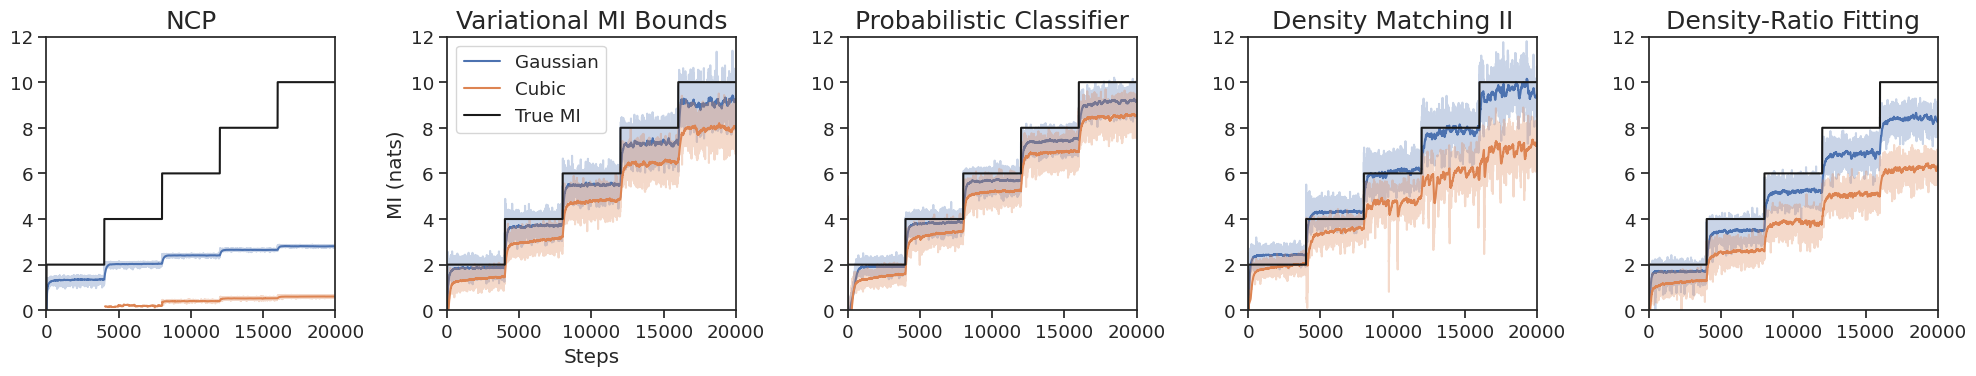

In [2]:
estimator_lists = [
    "ncp",
    "variational_f_js",
    "probabilistic_classifier",
    # "density_matching_lagrange",
    "density_matching",
    "density_ratio_fitting",
]  # , 'squared_mutual_information']

batch_size = data_params["batch_size"]
mi_numpys = dict(np.load(f"ours_mi_values_{str(batch_size)}.npz", allow_pickle=True))
mi_numpys_cubic = dict(np.load(f"ours_mi_values_cubic_{str(batch_size)}.npz", allow_pickle=True))
mi_numpys["concat"].item()[ESTIMATORE] = mis2
# mi_numpys_cubic["concat"].item()[ESTIMATORE] = mis_dict["cubic"]


def find_name(name):
    if "dv_clip_" in name:
        clip = name.split("_")[-1]
        return f"dv_clip_ ($\\tau = {clip}$)"
    else:
        return {
            "infonce": "CPC",
            "js": "JS",
            "nwj": "NWJ",
            "dv": "DV (MINE)",
            "smile": "SMILE",  # we use 5.0 #'SMILE ($\\tau = \\infty$)',
            "variational_f_js": "Variational MI Bounds",
            "probabilistic_classifier": "Probabilistic Classifier",
            "density_matching": "Density Matching II",
            "density_matching_lagrange": "Density Matching I",
            "density_ratio_fitting": "Density-Ratio Fitting",
            "squared_mutual_information": "SMI",
            "ncp": "NCP",
        }[name]


def find_legend(label):
    return {"concat": "Joint critic", "separable": "Separable critic"}[label]


ncols = len(estimator_lists)
nrows = 1
fig, axs = plt.subplots(nrows, ncols, figsize=(4 * ncols, 4 * nrows))
axs = np.ravel(axs)

mi_true = mi_schedule(opt_params["iterations"])

for i, estimator in enumerate(estimator_lists):
    key = f"{estimator}"
    plt.sca(axs[i])
    plt.title(find_name(key), fontsize=18)
    for net in ["concat"]:
        mis = mi_numpys[net].item()[key]
        mis_cubic = mi_numpys_cubic[net].item()[key]
        # print(mis.shape)
        EMA_SPAN = 200
        # print(type(np.arange(0, 20000)))
        # p1 = plt.scatter(x=np.arange(0, 20000), y=mis, alpha=0.3)
        mis_smooth = pd.Series(mis).ewm(span=EMA_SPAN).mean()
        p1 = plt.plot(mis, alpha=0.3)[0]
        plt.plot(mis_smooth, c=p1.get_color(), label="Gaussian")
        p2 = plt.plot(mis_cubic, alpha=0.3)[0]
        mis_smooth_cubic = pd.Series(mis_cubic).ewm(span=EMA_SPAN).mean()
        plt.plot(mis_smooth_cubic, c=p2.get_color(), label="Cubic")
    plt.ylim(0, 12)
    plt.xlim(0, 20000)
    plt.plot(mi_true, color="k", label="True MI")
    if estimator == "variational_f_js":
        plt.ylabel("MI (nats)")
        plt.xlabel("Steps")
        # plt.axhline(np.log(128), color='k', ls='--', label='log(bs)')
        plt.legend()

plt.gcf().tight_layout()
plt.savefig(f"ours_mi_gauss_results_{str(batch_size)}.pdf", bbox_inches=None)